In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from data_preprocessing import process_resstock_data
from models import MLPModel, LinearRegressionModel
from pvalues import get_pvalues

# Load data

### Setpoint timeseries

In [2]:
# full_heating_timeseries, full_cooling_timeseries = generate_setpoint_timeseries(
#     cooling_start_date = "2018-06-01",
#     cooling_end_date = "2018-10-31",
#     combine = False
# )

In [3]:
# # Save heaitng and cooling timeseries to pickle
# with open('/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/data/consumption/full_heating_timeseries.pkl', 'wb') as f:
#     pickle.dump(full_heating_timeseries, f)
# with open('/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/data/consumption/full_cooling_timeseries.pkl', 'wb') as f:
#     pickle.dump(full_cooling_timeseries, f)

In [4]:
# # Load full heating and cooling timeseries
# with open('/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/data/consumption/full_heating_timeseries.pkl', 'rb') as f:
#     full_heating_timeseries = pickle.load(f)
# with open('/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/data/consumption/full_cooling_timeseries.pkl', 'rb') as f:
#     full_cooling_timeseries = pickle.load(f)

### Weather data

In [5]:
weather_data = pd.read_csv("/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/data/consumption/G2500170_2018.csv")

In [6]:
weather_data.head()

,date_time,Dry Bulb Temperature [°C],Relative Humidity [%],Wind Speed [m/s],Wind Direction [Deg],Global Horizontal Radiation [W/m2],Direct Normal Radiation [W/m2],Diffuse Horizontal Radiation [W/m2]
0,2018-01-01 01:00:00,-17.2,47.00,7.2,310.0,0.0,0.0,0.0
1,2018-01-01 02:00:00,-17.8,46.83,6.7,300.0,0.0,0.0,0.0
2,2018-01-01 03:00:00,-18.9,55.19,2.1,260.0,0.0,0.0,0.0
3,2018-01-01 04:00:00,-18.9,51.97,4.1,280.0,0.0,0.0,0.0
4,2018-01-01 05:00:00,-19.4,54.51,3.6,280.0,0.0,0.0,0.0


### ResStock

In [7]:
resstock = pd.read_parquet("/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/data/consumption/MA_baseline_metadata_and_annual_results.parquet")

### Building timeseries

In [8]:
building_data = pd.read_parquet("/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/data/consumption/1000-0.parquet")

In [9]:
# loop through each column that containts "temp"
for col in building_data.columns:
    if "temp" in col.lower():
        print(col)

out.outdoor_air_dryblub_temp.c
out.zone_mean_air_temp.air_source_heat_pump_airloop_ret_air_zone.c
out.zone_mean_air_temp.attic_unvented.c
out.zone_mean_air_temp.attic_vented.c
out.zone_mean_air_temp.basement_unconditioned.c
out.zone_mean_air_temp.central_ac_airloop_ret_air_zone.c
out.zone_mean_air_temp.central_ac_and_furnace_airloop_ret_air_zone.c
out.zone_mean_air_temp.conditioned_space.c
out.zone_mean_air_temp.crawlspace_unvented.c
out.zone_mean_air_temp.crawlspace_vented.c
out.zone_mean_air_temp.furnace_airloop_ret_air_zone.c
out.zone_mean_air_temp.garage.c
out.zone_mean_air_temp.ground_source_heat_pump_airloop_ret_air_zone.c


In [10]:
building_data[["out.zone_mean_air_temp.conditioned_space.c", "timestamp"]].head()

,out.zone_mean_air_temp.conditioned_space.c,timestamp
bldg_id,,
1000,21.662988,2018-01-01 00:15:00
1000,21.663375,2018-01-01 00:30:00
1000,21.666023,2018-01-01 00:45:00
1000,21.662103,2018-01-01 01:00:00
1000,21.666348,2018-01-01 01:15:00


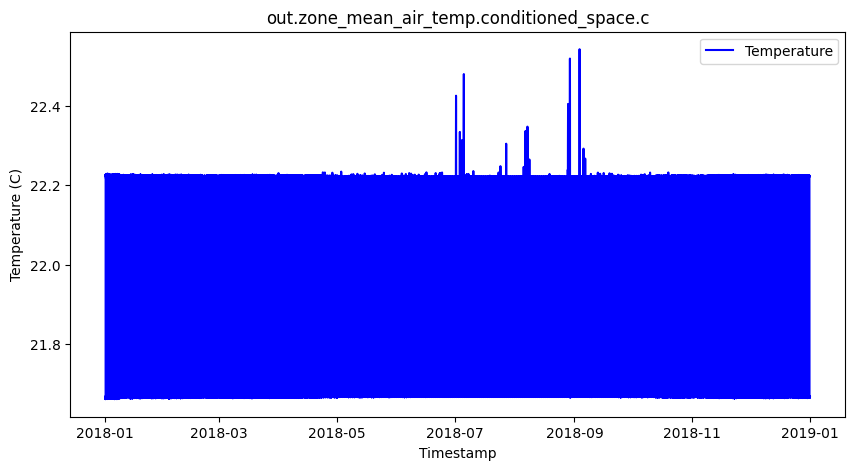

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(building_data["timestamp"], building_data["out.zone_mean_air_temp.conditioned_space.c"], label='Temperature', color='blue')
plt.xlabel('Timestamp')
plt.ylabel('Temperature (C)')
plt.title("out.zone_mean_air_temp.conditioned_space.c")
plt.legend()
plt.show()

In [12]:
resstock["in.cooling_setpoint"].loc[1000]

'68F'

In [13]:
temp_timeseries = building_data[["timestamp", "out.zone_mean_air_temp.conditioned_space.c"]].copy()

# Rename columns for clarity
temp_timeseries.columns = ["timestamp", "indoor_temp"]

# ResStock transform

In [14]:
columns = [
    "in.bedrooms",              # int
    "in.duct_leakage_and_insulation",    # Separate into leakage / insulation: X% / (Uniinsulated/R-n)
    "in.duct_location",         # Places of the house
    "in.geometry_floor_area",   # 1000-1499, ...
    "in.geometry_stories",      # int
    "in.geometry_wall_type",    # Materials
    "in.ground_thermal_conductivity",   # float
    "in.hvac_has_ducts",    # Yes / No
    "in.insulation_ceiling",    # R-n / Uninsulated
    "in.insulation_floor",      # R-n / Uninsulated
    "in.insulation_foundation_wall",    # Wall R-n, Exterior
    "in.insulation_roof",       # Finished / Unfinished, R-n
    "in.insulation_wall",       # Material, Uninsulated / R-n
    "in.occupants",         # int
    "in.orientation",       # North, Northwest...
    "in.roof_material",     # Material
    "in.sqft",              # int
    "in.windows"    # Single/Double/Triple, Low-E/Clear, Metal/Non-metal, Air/Exterior Clear Storm, (L/M-Gain)
    "in.window_areas",
    "in.vintage",
]

In [15]:
columns_processed = [
    "in.bedrooms_processed",              # int
    "in.duct_leakage_processed",
    "in.duct_insulation_processed",    # Separate into leakage / insulation: X% / (Uniinsulated/R-n)
    "in.duct_location_processed",         # Places of the house
    "in.geometry_floor_area_processed",   # 1000-1499, ...
    "in.geometry_stories_processed",      # int
    "in.geometry_wall_type_processed",    # Materials
    "in.ground_thermal_conductivity_processed",   # float
    "in.hvac_has_ducts_processed",    # Yes / No
    "in.insulation_ceiling_processed",    # R-n / Uninsulated
    "in.insulation_floor_processed",      # R-n / Uninsulated
    "in.insulation_foundation_wall_processed",    # Wall R-n, Exterior
    "in.insulation_roof_processed",       # Finished / Unfinished, R-n
    "in.insulation_wall_processed",       # Material, Uninsulated / R-n
    "in.occupants_processed",         # int
    "in.orientation_processed",       # North, Northwest...
    "in.roof_material_processed",     # Material
    "in.sqft_processed",              # int
    "in.windows_processed", # Single/Double/Triple, Low-E/Clear, Metal/Non-metal, Air/Exterior Clear Storm, (L/M-Gain)
    "in.window_areas_processed",
    "in.vintage_processed",
    
]

In [16]:
resstock_processed = process_resstock_data(resstock)

In [17]:
resstock_processed["in.vintage_processed"].value_counts()

in.vintage_processed
1930    3820
1970    1386
1950    1312
1980    1269
1960    1220
1990     895
2000     825
1940     614
2010     366
Name: count, dtype: int64

In [18]:
usable_resstock = resstock_processed[columns_processed]

In [19]:
usable_resstock.head()

,in.bedrooms_processed,in.duct_leakage_processed,in.duct_insulation_processed,in.duct_location_processed,in.geometry_floor_area_processed,in.geometry_stories_processed,in.geometry_wall_type_processed,in.ground_thermal_conductivity_processed,in.hvac_has_ducts_processed,in.insulation_ceiling_processed,...,in.insulation_foundation_wall_processed,in.insulation_roof_processed,in.insulation_wall_processed,in.occupants_processed,in.orientation_processed,in.roof_material_processed,in.sqft_processed,in.windows_processed,in.window_areas_processed,in.vintage_processed
bldg_id,,,,,,,,,,,,,,,,,,,,,
10,3,10,0,4,1749,1,1,1.4,1,5,...,1,0,0,6,1,3,1228,2,18,1950
122,1,0,0,0,874,5,1,1.4,0,0,...,1,6,0,1,5,0,623,2,18,1950
129,1,0,0,0,874,2,2,1.1,0,0,...,1,5,1,1,4,0,623,1,15,1970
150,2,0,0,0,1749,3,1,1.1,0,0,...,0,3,4,1,3,0,1138,2,15,2000
183,3,0,0,0,1749,1,1,1.4,0,1,...,1,0,0,2,3,1,1228,2,18,1930


In [20]:
building_resstock = np.array(usable_resstock.loc[1000])

In [21]:
building_resstock

array([3.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.499e+03, 1.000e+00,
       2.000e+00, 1.400e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
       5.000e+00, 0.000e+00, 3.000e+00, 0.000e+00, 0.000e+00, 1.682e+03,
       2.000e+00, 1.500e+01, 1.930e+03])

# Transform data

In [22]:
def get_cols(building_data: pd.DataFrame, building_id: int) -> str:

    try:
        building = building_data.loc[building_id]
    except:
        raise ValueError("Building ID not found in the dataset")

    match building["in.heating_fuel"]:
        case  "Natural Gas":
            return "out.natural_gas.heating.energy_consumption"
        case "Electricity":
            return "out.electricity.heating.energy_consumption"
        case "Fuel Oil":
            return "out.fuel_oil.heating.energy_consumption"
        case "Propane":
            return "out.propane.heating.energy_consumption"
        case _:
            return "out.electricity.heating.energy_consumption"

In [23]:
weather_data.columns

Index(['date_time', 'Dry Bulb Temperature [°C]', 'Relative Humidity [%]',
       'Wind Speed [m/s]', 'Wind Direction [Deg]',
       'Global Horizontal Radiation [W/m2]', 'Direct Normal Radiation [W/m2]',
       'Diffuse Horizontal Radiation [W/m2]'],
      dtype='object')

In [24]:
weather_data.head()

,date_time,Dry Bulb Temperature [°C],Relative Humidity [%],Wind Speed [m/s],Wind Direction [Deg],Global Horizontal Radiation [W/m2],Direct Normal Radiation [W/m2],Diffuse Horizontal Radiation [W/m2]
0,2018-01-01 01:00:00,-17.2,47.00,7.2,310.0,0.0,0.0,0.0
1,2018-01-01 02:00:00,-17.8,46.83,6.7,300.0,0.0,0.0,0.0
2,2018-01-01 03:00:00,-18.9,55.19,2.1,260.0,0.0,0.0,0.0
3,2018-01-01 04:00:00,-18.9,51.97,4.1,280.0,0.0,0.0,0.0
4,2018-01-01 05:00:00,-19.4,54.51,3.6,280.0,0.0,0.0,0.0


In [25]:
# Change date time column name to timestamp
weather_data.rename(columns={'date_time': "timestamp"}, inplace=True)
weather_data.set_index('timestamp', inplace=True)
weather_data.index = pd.to_datetime(weather_data.index)

# Delete all columns except dry bulb temperature
weather_data = weather_data[["Dry Bulb Temperature [°C]", "Direct Normal Radiation [W/m2]"]]
weather_data.rename(columns={"Dry Bulb Temperature [°C]": "temperature"}, inplace=True)

# Create an entry for 2018-01-01 00:00:00
new_row = pd.DataFrame({'temperature': weather_data.iloc[0]['temperature']}, index=[pd.to_datetime('2018-01-01 00:00:00')])
weather_data = pd.concat([new_row, weather_data])

# Remove last 19 rows
weather_data = weather_data[:-24]

In [26]:
weather_data.bfill(inplace=True)
weather_data.ffill(inplace=True)

In [27]:
building_id = 1000

In [28]:
col_to_use = get_cols(resstock, building_id)
consumption_timeseries = building_data[["timestamp", col_to_use]]

# Resample to hourly data
consumption_timeseries["timestamp"] = pd.to_datetime(consumption_timeseries["timestamp"])
consumption_timeseries.set_index("timestamp", inplace=True)
consumption_timeseries = consumption_timeseries.resample("H").mean()
consumption_timeseries = consumption_timeseries[col_to_use]

consumption_timeseries = consumption_timeseries[:-24]

# Turn into dataframe
consumption_timeseries = pd.DataFrame(consumption_timeseries)
consumption_timeseries.rename(columns={col_to_use: "consumption"}, inplace=True)

/var/folders/bw/4qyc6pj92bdb1bv22yhll2zw0000gn/T/ipykernel_5148/3969840236.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consumption_timeseries["timestamp"] = pd.to_datetime(consumption_timeseries["timestamp"])
/var/folders/bw/4qyc6pj92bdb1bv22yhll2zw0000gn/T/ipykernel_5148/3969840236.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  consumption_timeseries = consumption_timeseries.resample("H").mean()


In [29]:
exog_variables = pd.merge(
    consumption_timeseries,
    weather_data,
    left_index=True,
    right_index=True,
)

In [30]:
exog_variables.head()

,consumption,temperature,Direct Normal Radiation [W/m2]
timestamp,,,
2018-01-01 00:00:00,4.691970,-17.2,0.0
2018-01-01 01:00:00,5.008804,-17.2,0.0
2018-01-01 02:00:00,4.799112,-17.8,0.0
2018-01-01 03:00:00,4.963452,-18.9,0.0
2018-01-01 04:00:00,5.047929,-18.9,0.0


# Data Plot

In [31]:
train_size = 0.8
endog_train = temp_timeseries[:int(train_size * len(temp_timeseries))]
endog_test = temp_timeseries[int(train_size * len(temp_timeseries)):]

exog_train = exog_variables[:int(train_size * len(exog_variables))]
exog_test = exog_variables[int(train_size * len(exog_variables)):]

endog_train.set_index("timestamp", inplace=True)
endog_test.set_index("timestamp", inplace=True)

In [32]:
exog_train.head()

,consumption,temperature,Direct Normal Radiation [W/m2]
timestamp,,,
2018-01-01 00:00:00,4.691970,-17.2,0.0
2018-01-01 01:00:00,5.008804,-17.2,0.0
2018-01-01 02:00:00,4.799112,-17.8,0.0
2018-01-01 03:00:00,4.963452,-18.9,0.0
2018-01-01 04:00:00,5.047929,-18.9,0.0


In [33]:
endog_train.head(10)

,indoor_temp
timestamp,
2018-01-01 00:15:00,21.662988
2018-01-01 00:30:00,21.663375
2018-01-01 00:45:00,21.666023
2018-01-01 01:00:00,21.662103
2018-01-01 01:15:00,21.666348
2018-01-01 01:30:00,21.663899
2018-01-01 01:45:00,21.664022
2018-01-01 02:00:00,21.667390
2018-01-01 02:15:00,21.669242


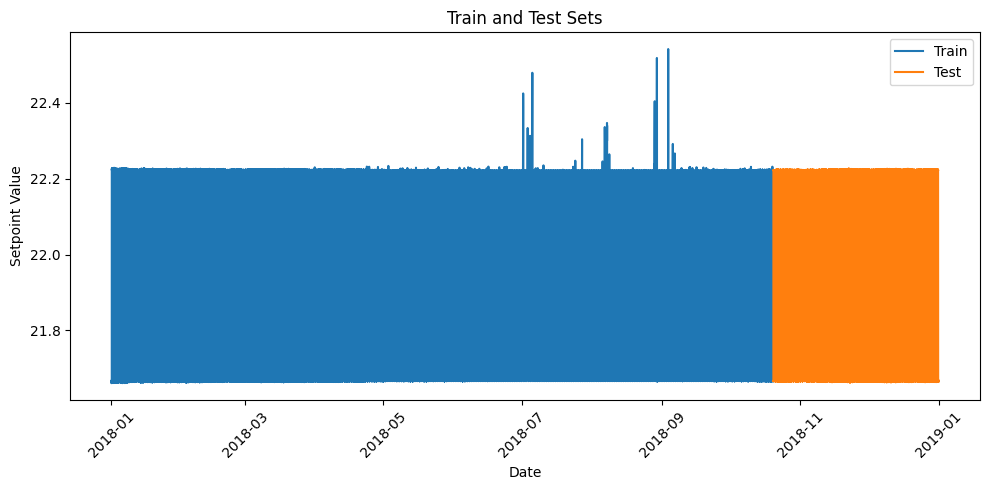

In [34]:
# Plot the training and test sets
plt.figure(figsize=(10, 5))
plt.plot(endog_train.index, endog_train["indoor_temp"], label="Train")
plt.plot(endog_test.index, endog_test["indoor_temp"], label="Test")
plt.title("Train and Test Sets")
plt.xlabel("Date")
plt.ylabel("Setpoint Value")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Train and evaluate fns

In [35]:
# Training function
def train(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for sequences, labels in train_loader:
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(sequences)
            loss = criterion(outputs, labels)  # Unsqueeze labels to match output dim
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}')

In [36]:
# Predict
def evaluate(model, test_loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for sequences, labels in test_loader:
            outputs = model(sequences)
            predictions.append(outputs.numpy())
            actuals.append(labels.numpy())
    return np.concatenate(predictions), np.concatenate(actuals)

# MLP

In [37]:
# input_size = 69
# hidden_size_1 = 64
# hidden_size_2 = 32
# output_size = 1

In [38]:
# heating_model = MLPModel(
#     input_size, 
#     hidden_size_1=hidden_size_1, 
#     hidden_size_2=hidden_size_2,
#     output_size=output_size)

In [39]:
# # Loss and optimizer
# heating_criterion = nn.MSELoss()
# heating_optimizer = optim.Adam(heating_model.parameters(), lr=0.0001)

## Heating

In [40]:
# num_epochs = 100
# train(heating_model, heating_train_loader, heating_criterion, heating_optimizer, num_epochs)

In [41]:
# # Predict
# heating_predictions, heating_actuals = evaluate(heating_model, heating_test_loader)

In [42]:
# # Plot train, test and predictions
# plt.figure(figsize=(10, 5))
# plt.plot(heating_train_timeseries.index, heating_train_timeseries["setpoint"], label="Train")
# plt.plot(heating_test_timeseries.index, heating_test_timeseries["setpoint"], label="Test")
# plt.plot(heating_test_timeseries.index[13:], heating_predictions, label="Predicted")
# plt.title("Linear Regression Predictions")
# plt.xlabel("Time Step")
# plt.ylabel("Setpoint Value")
# plt.legend()
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

## Cooling

In [43]:
# input_size = 69
# hidden_size_1 = 64
# hidden_size_2 = 32
# output_size = 1

In [44]:
# cooling_model = MLPModel(
#     input_size, 
#     hidden_size_1=hidden_size_1, 
#     hidden_size_2=hidden_size_2,
#     output_size=output_size)

In [45]:
# # Loss and optimizer
# cooling_criterion = nn.MSELoss()
# cooling_optimizer = optim.Adam(cooling_model.parameters(), lr=0.0001)

In [46]:
# num_epochs = 100
# train(cooling_model, cooling_train_loader, cooling_criterion, cooling_optimizer, num_epochs)

In [47]:
# # Predict
# cooling_predictions, cooling_actuals = evaluate(cooling_model, cooling_test_loader)

In [48]:
# # Plot train, test and predictions
# plt.figure(figsize=(10, 5))
# plt.plot(cooling_train_timeseries.index, cooling_train_timeseries["setpoint"], label="Train")
# plt.plot(cooling_test_timeseries.index, cooling_test_timeseries["setpoint"], label="Test")
# plt.plot(cooling_test_timeseries.index[13:], cooling_predictions, label="Predicted")
# plt.title("Linear Regression Predictions")
# plt.xlabel("Time Step")
# plt.ylabel("Setpoint Value")
# plt.legend()
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

## Akaike

In [49]:
# def compute_aic(y_true, y_pred, num_params):
#     n = y_true.numel()
#     residuals = y_true - y_pred
#     rss = torch.sum(residuals ** 2).item()
#     sigma2 = rss / n
#     log_likelihood = -n/2 * (np.log(2 * np.pi * sigma2) + 1)
#     aic = 2 * num_params - 2 * log_likelihood
#     return aic

In [50]:
# heating_num_params = sum(p.numel() for p in heating_model.parameters() if p.requires_grad)

In [51]:
# heating_aic = compute_aic(
#     torch.tensor(heating_actuals), 
#     torch.tensor(heating_predictions), 
#     heating_num_params
# )

In [52]:
# heating_aic

In [53]:
# cooling_num_params = sum(p.numel() for p in cooling_model.parameters() if p.requires_grad)
# cooling_aic = compute_aic(
#     torch.tensor(cooling_actuals), 
#     torch.tensor(cooling_predictions), 
#     cooling_num_params
# )
# cooling_aic

# ARIMA

## Add lag to variables

In [54]:
# import warnings
# warnings.filterwarnings("ignore")

# # Add lag of 1 to consumption, and create new temperature column with lag 1
# heating_exog_train["temperature_lag_1"] = heating_exog_train["temperature"].shift(1)
# heating_exog_train["consumption_lag_1"] = heating_exog_train["consumption"].shift(1)
# heating_exog_train.drop(columns=["consumption"], inplace=True)
# heating_exog_train.bfill(inplace=True)

# heating_exog_test["temperature_lag_1"] = heating_exog_test["temperature"].shift(1)
# heating_exog_test["consumption_lag_1"] = heating_exog_test["consumption"].shift(1)
# heating_exog_test.drop(columns=["consumption"], inplace=True)
# heating_exog_test.bfill(inplace=True)

# cooling_exog_train["temperature_lag_1"] = cooling_exog_train["temperature"].shift(1)
# cooling_exog_train["consumption_lag_1"] = cooling_exog_train["consumption"].shift(1)
# cooling_exog_train.drop(columns=["consumption"], inplace=True)
# cooling_exog_train.bfill(inplace=True)

# cooling_exog_test["temperature_lag_1"] = cooling_exog_test["temperature"].shift(1)
# cooling_exog_test["consumption_lag_1"] = cooling_exog_test["consumption"].shift(1)
# cooling_exog_test.drop(columns=["consumption"], inplace=True)
# cooling_exog_test.bfill(inplace=True)

In [55]:
# heating_exog_train.head()

## Heating

In [56]:
# # Make sure heating_endog_train and heating_exog_train have hourly frequency
# heating_endog_train = heating_endog_train.asfreq('h')
# heating_exog_train = heating_exog_train.asfreq('h')

# heating_endog_train.ffill(inplace=True)
# heating_exog_train.ffill(inplace=True)
# heating_endog_train.bfill(inplace=True)
# heating_exog_train.bfill(inplace=True)

In [57]:
# heating_arima_model = ARIMA(
#     endog=heating_endog_train,
#     exog=heating_exog_train,
#     order=(0, 0, 0),
#     freq="h",
# )

In [58]:
# heating_arima_model_fit = heating_arima_model.fit()

In [59]:
# print(heating_arima_model_fit.summary())

In [60]:
# # Plot ACF and PACF

# fig, ax = plt.subplots(2, 1, figsize=(10, 8))
# plot_acf(heating_arima_model_fit.resid, lags=50, ax=ax[0])
# plot_pacf(heating_arima_model_fit.resid, lags=50, ax=ax[1])
# plt.title("ACF and PACF")
# plt.tight_layout()
# plt.show()

In [61]:
# # Predict
# predictions = heating_arima_model_fit.get_forecast(steps=len(heating_endog_test), exog=heating_exog_test)
# predicted_mean = predictions.predicted_mean
# predicted_conf_int = predictions.conf_int()
# lower_limits = predicted_conf_int.iloc[:, 0]
# upper_limits = predicted_conf_int.iloc[:, 1]
# predicted_mean = pd.Series(predicted_mean, index=heating_endog_test.index)

In [62]:
# # Plot predictions
# plt.figure(figsize=(10, 5))
# plt.plot(heating_endog_train.index, heating_endog_train["setpoint"], label="Train")
# plt.plot(heating_endog_test.index, heating_endog_test["setpoint"], label="Test")
# plt.plot(predicted_mean.index, predicted_mean, label="Predicted")
# plt.title("ARIMA Predictions")
# plt.xlabel("Date")
# plt.ylabel("Setpoint Value")
# plt.legend()
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

In [63]:
# heating_arima_model_fit.params

## Cooling

In [64]:
# # Make sure heating_endog_train and heating_exog_train have hourly frequency
# cooling_endog_train = cooling_endog_train.asfreq('h')
# cooling_exog_train = cooling_exog_train.asfreq('h')

# cooling_endog_train.ffill(inplace=True)
# cooling_exog_train.ffill(inplace=True)
# cooling_endog_train.bfill(inplace=True)
# cooling_exog_train.bfill(inplace=True)

In [65]:
# cooling_arima_model = ARIMA(
#     endog=cooling_endog_train,
#     exog=cooling_exog_train,
#     order=(1, 0, 0),
#     seasonal_order=(1, 0, 0, 24),
#     freq="h",
# )

In [66]:
# cooling_arima_model_fit = cooling_arima_model.fit()

In [67]:
# print(cooling_arima_model_fit.summary())

In [68]:
# # Plot ACF and PACF

# fig, ax = plt.subplots(2, 1, figsize=(10, 8))
# plot_acf(cooling_arima_model_fit.resid, lags=50, ax=ax[0])
# plot_pacf(cooling_arima_model_fit.resid, lags=50, ax=ax[1])
# plt.title("ACF and PACF")
# plt.tight_layout()
# plt.show()

In [69]:
# # Predict
# predictions = cooling_arima_model_fit.get_forecast(steps=len(cooling_endog_test), exog=cooling_exog_test)
# predicted_mean = predictions.predicted_mean
# predicted_conf_int = predictions.conf_int()
# lower_limits = predicted_conf_int.iloc[:, 0]
# upper_limits = predicted_conf_int.iloc[:, 1]
# predicted_mean = pd.Series(predicted_mean, index=cooling_endog_test.index)

In [70]:
# # Plot predictions
# plt.figure(figsize=(10, 5))
# plt.plot(cooling_endog_train.index, cooling_endog_train["setpoint"], label="Train")
# plt.plot(cooling_endog_test.index, cooling_endog_test["setpoint"], label="Test")
# plt.plot(predicted_mean.index, predicted_mean, label="Predicted")
# plt.title("ARIMA Predictions")
# plt.xlabel("Date")
# plt.ylabel("Setpoint Value")
# plt.legend()
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

In [71]:
# # Print arima parameters
# print(cooling_arima_model_fit.params)

# Linear Regression

In [72]:
train_data = pd.merge(endog_train, exog_train, left_index=True, right_index=True)
test_data = pd.merge(endog_test, exog_test, left_index=True, right_index=True)

In [73]:
train_data.head()

,indoor_temp,consumption,temperature,Direct Normal Radiation [W/m2]
timestamp,,,,
2018-01-01 01:00:00,21.662103,5.008804,-17.2,0.0
2018-01-01 02:00:00,21.667390,4.799112,-17.8,0.0
2018-01-01 03:00:00,21.661066,4.963452,-18.9,0.0
2018-01-01 04:00:00,22.224965,5.047929,-18.9,0.0
2018-01-01 05:00:00,22.222402,5.049908,-19.4,0.0


In [74]:
# Set heating labels to the setpoint column
train_labels = train_data["indoor_temp"].values
test_labels = test_data["indoor_temp"].values

In [75]:
# Shift setpoint so that each column has the value of the previous hour
train_data["indoor_temp"] = train_data["indoor_temp"].shift(1)
test_data["indoor_temp"] = test_data["indoor_temp"].shift(1)

train_data.ffill(inplace=True)
test_data.ffill(inplace=True)
train_data.bfill(inplace=True)
test_data.bfill(inplace=True)

In [76]:
# Create new lag_temperature column with lag 1
train_data["lag_temperature"] = train_data["temperature"].shift(1)
test_data["lag_temperature"] = test_data["temperature"].shift(1)

train_data.ffill(inplace=True)
test_data.ffill(inplace=True)
train_data.bfill(inplace=True)
test_data.bfill(inplace=True)

In [77]:
class LinearRegressionDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)
    
    def convert_to_numpy(self):
        return self.data

In [78]:
lr_dataset_train = LinearRegressionDataset(train_data.values, train_labels)
lr_dataset_test = LinearRegressionDataset(test_data.values, test_labels)

In [79]:
batch_size = 32

lr_dataloader_train = DataLoader(lr_dataset_train, batch_size=batch_size, shuffle=True)
lr_dataloader_test = DataLoader(lr_dataset_test, batch_size=batch_size, shuffle=False)

In [80]:
train_data.head()

,indoor_temp,consumption,temperature,Direct Normal Radiation [W/m2],lag_temperature
timestamp,,,,,
2018-01-01 01:00:00,21.662103,5.008804,-17.2,0.0,-17.2
2018-01-01 02:00:00,21.662103,4.799112,-17.8,0.0,-17.2
2018-01-01 03:00:00,21.667390,4.963452,-18.9,0.0,-17.8
2018-01-01 04:00:00,21.661066,5.047929,-18.9,0.0,-18.9
2018-01-01 05:00:00,22.224965,5.049908,-19.4,0.0,-18.9


In [111]:
lr_model = LinearRegressionModel(input_size=train_data.shape[1], output_size=1, bias=False)

In [112]:
# Loss and optimizer
lr_criterion = nn.MSELoss()
lr_optimizer = optim.Adam(lr_model.parameters(), lr=0.0001)

In [113]:
num_epochs = 100
train(lr_model, lr_dataloader_train, lr_criterion, lr_optimizer, num_epochs)

Epoch 1/100, Loss: 13055.2862
Epoch 2/100, Loss: 11363.8737
Epoch 3/100, Loss: 9905.8462
Epoch 4/100, Loss: 8535.6235
Epoch 5/100, Loss: 7363.0676
Epoch 6/100, Loss: 6323.0429
Epoch 7/100, Loss: 5384.1491
Epoch 8/100, Loss: 4583.5367
Epoch 9/100, Loss: 3874.7366
Epoch 10/100, Loss: 3270.6944
Epoch 11/100, Loss: 2742.1046
Epoch 12/100, Loss: 2304.3308
Epoch 13/100, Loss: 1925.7777
Epoch 14/100, Loss: 1611.7901
Epoch 15/100, Loss: 1353.1510
Epoch 16/100, Loss: 1143.7839
Epoch 17/100, Loss: 965.0085
Epoch 18/100, Loss: 823.9314
Epoch 19/100, Loss: 705.3641
Epoch 20/100, Loss: 609.4403
Epoch 21/100, Loss: 528.2727
Epoch 22/100, Loss: 461.1851
Epoch 23/100, Loss: 405.0048
Epoch 24/100, Loss: 356.8967
Epoch 25/100, Loss: 315.1354
Epoch 26/100, Loss: 279.3055
Epoch 27/100, Loss: 248.0286
Epoch 28/100, Loss: 219.8502
Epoch 29/100, Loss: 194.7023
Epoch 30/100, Loss: 172.1489
Epoch 31/100, Loss: 151.9258
Epoch 32/100, Loss: 133.3845
Epoch 33/100, Loss: 116.6981
Epoch 34/100, Loss: 101.5985
Epoch

In [114]:
# predict
lr_predictions, lr_actuals = evaluate(lr_model, lr_dataloader_test)

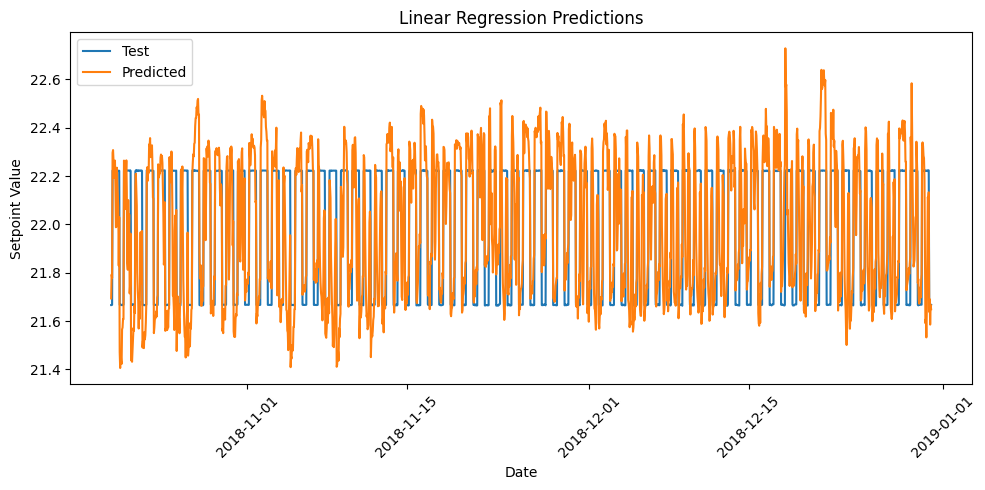

In [115]:
# plot predictions
plt.figure(figsize=(10, 5))
plt.plot(test_data.index, test_data["indoor_temp"], label="Test")
plt.plot(test_data.index, lr_predictions, label="Predicted")
plt.title("Linear Regression Predictions")
plt.xlabel("Date")
plt.ylabel("Setpoint Value")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [116]:
for param in lr_model.parameters():
    for num in param:
        try:
            for p in num:
                print(p.item())
        except:
            print(num.item())

0.9633010029792786
0.4749230146408081
0.0662851557135582
-0.0006489827646873891
-0.022714387625455856


In [121]:
train_data.head()

,indoor_temp,consumption,temperature,Direct Normal Radiation [W/m2],lag_temperature
timestamp,,,,,
2018-01-01 01:00:00,21.662103,5.008804,-17.2,0.0,-17.2
2018-01-01 02:00:00,21.662103,4.799112,-17.8,0.0,-17.2
2018-01-01 03:00:00,21.667390,4.963452,-18.9,0.0,-17.8
2018-01-01 04:00:00,21.661066,5.047929,-18.9,0.0,-18.9
2018-01-01 05:00:00,22.224965,5.049908,-19.4,0.0,-18.9


### P-values

In [117]:
# Get predictions on train set
lr_train_predictions, lr_train_actuals = evaluate(lr_model, lr_dataloader_train)

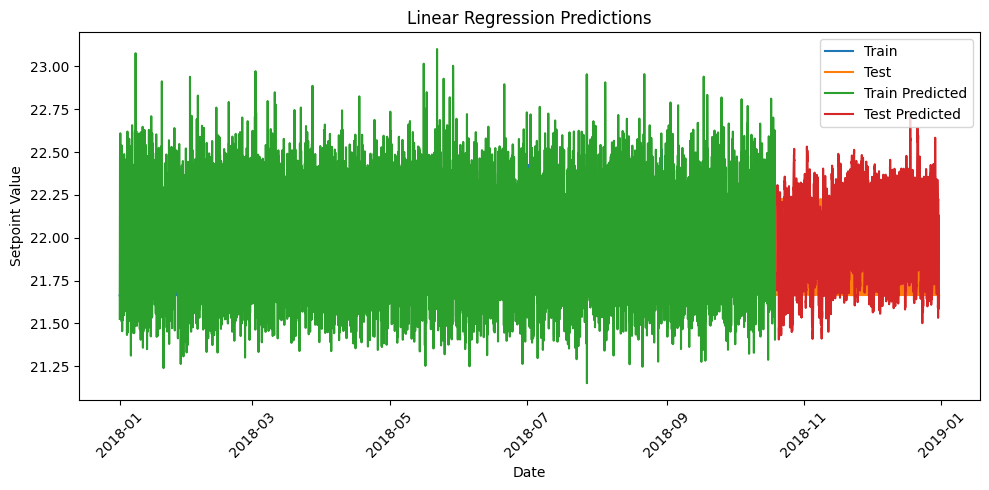

In [118]:
# plot predictions
plt.figure(figsize=(10, 5))
plt.plot(train_data.index, train_data["indoor_temp"], label="Train")
plt.plot(test_data.index, test_data["indoor_temp"], label="Test")
plt.plot(train_data.index, lr_train_predictions, label="Train Predicted")
plt.plot(test_data.index, lr_predictions, label="Test Predicted")
plt.title("Linear Regression Predictions")
plt.xlabel("Date")
plt.ylabel("Setpoint Value")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [119]:
p_values = get_pvalues(
    lr_model, 
    lr_dataset_train, 
    lr_train_actuals, 
    lr_train_predictions
)

In [120]:
for i, col in enumerate(train_data.columns):
    print(col + ":")
    print("\t-  ", p_values[i])

indoor_temp:
	-   0.0
consumption:
	-   0.6547448673911398
temperature:
	-   0.8616911613103377
Direct Normal Radiation [W/m2]:
	-   0.6863913074929511
lag_temperature:
	-   0.9505606575935701


## Save model

In [122]:
models_folder_path = "/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/consumption/models"

In [123]:
# Save model
torch.save(lr_model.state_dict(), f"{models_folder_path}/linear_regression_model.pth")

## Load model and predict

In [124]:
# load model
loaded_lr_model = LinearRegressionModel(input_size=train_data.shape[1], output_size=1, bias=False)
loaded_lr_model.load_state_dict(torch.load(f"{models_folder_path}/linear_regression_model.pth"))

<All keys matched successfully>

In [125]:
# Predict
loaded_lr_predictions, loaded_lr_actuals = evaluate(loaded_lr_model, lr_dataloader_test)

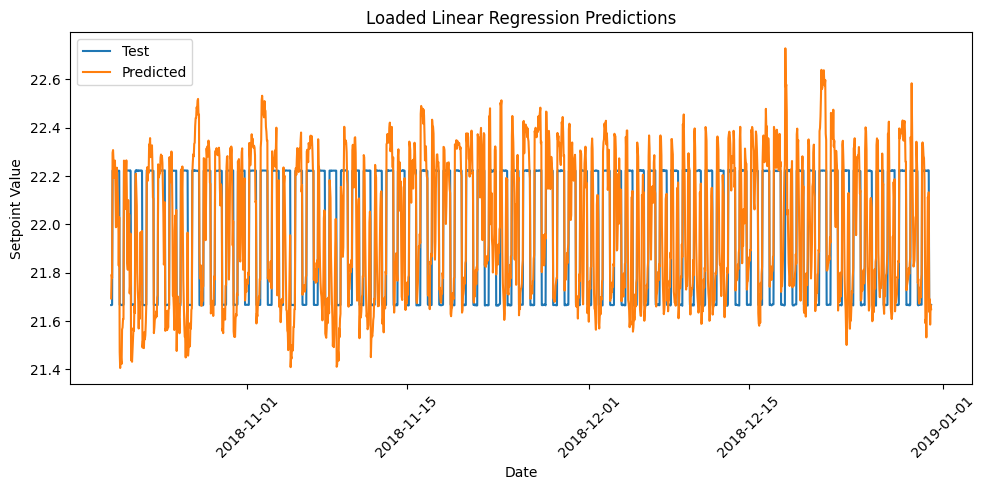

In [126]:
# Plot predictions
plt.figure(figsize=(10, 5))
plt.plot(test_data.index, test_data["indoor_temp"], label="Test")
plt.plot(test_data.index, loaded_lr_predictions, label="Predicted")
plt.title("Loaded Linear Regression Predictions")
plt.xlabel("Date")
plt.ylabel("Setpoint Value")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()